In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# XGBoost with Target-Count encoding of NAICS + DGI groups
Do the Target+Count encoding for all levels of the NAICS plus DGI hierarchy.  Use selected lambda_k

This is duplicative with A02 for metrics, but I want to look at feature importance, lift, etc.

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle, importlib

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot, sg_target_count_encoder
from sba_gnn.sba_gnn.sg_target_count_encoder import TargetCountEncoder

## Import Processed Dataset

In [6]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet')) 

##### Append DGI info

In [7]:
##### DGI info
embed_df = pd.read_parquet(Path(setup.parent_path).joinpath('63_DATA_embeddings_tsne_naics.parquet'))

In [8]:
# Group counts
naics_grp_counts = pd.read_csv(Path(setup.parent_path).joinpath('02_REPORT_naics_grp_stats_all.csv')) \
    [['level_0', 'count_grp']] \
    .drop_duplicates() \
    .set_axis(['naics_type', 'k'], axis=1)

In [9]:
naics_grp_k = naics_grp_counts['k'].drop_duplicates().sort_values().to_list()
naics_grp_k

[20.0, 106.0, 354.0, 834.0]

In [10]:
cluster_cols = sorted([c for c in embed_df if c.startswith('cluster_')],
                      reverse=True)
cluster_cols

['cluster_834',
 'cluster_354',
 'cluster_106',
 'cluster_020',
 'cluster_010',
 'cluster_003']

In [11]:
cluster_cols_sel = sorted([c for c in cluster_cols if int(c.split('_')[1]) in naics_grp_k],
                         reverse=True)
cluster_cols_sel

['cluster_834', 'cluster_354', 'cluster_106', 'cluster_020']

In [12]:
enc_cols = ['NAICS'] + cluster_cols_sel

In [13]:
sba_loans = sba_loans.drop(columns = cluster_cols_sel, errors='ignore') \
    .merge(embed_df[['NAICS_orig'] + cluster_cols_sel] \
               .rename(columns={'NAICS_orig':'NAICS'}),
           on='NAICS', how='left')

## Do the Encoding
Use the TargetCountEncoder to transform the NAICS feature to two columns per level of the NAICS hieararchy

In [14]:
train_df = sba_loans[sba_loans['dset'] == 'train']

In [15]:
# Create encoders
enc_dict = {f:TargetCountEncoder(lambda_k = setup.selected_lambda_k) for f in enc_cols}

In [16]:
# fit encoders
[enc_dict[f].fit(train_df[f], train_df['target']) for f in enc_cols]

[None, None, None, None, None]

In [17]:
with open(Path(setup.temp_path).joinpath('A23_DATA_encoder.pkl'), 'wb') as fout:
    pickle.dump(enc_dict, fout)

In [18]:
# Transform the data
enc_val = pd.concat([enc_dict[f].transform(sba_loans[f]) for f in enc_cols],
                    axis=1, keys=enc_cols)
enc_val.columns = [c[0] + '_' + c[1] for c in enc_val.columns]

In [19]:
enc_val.head(3)

,NAICS_response,NAICS_count,cluster_834_response,cluster_834_count,cluster_354_response,cluster_354_count,cluster_106_response,cluster_106_count,cluster_020_response,cluster_020_count
0,0.229316,160.0,0.231334,160.0,0.210680,160.0,0.161917,160.0,0.271491,160
1,0.141762,160.0,0.146818,160.0,0.131235,160.0,0.131107,160.0,0.136235,160
2,0.040818,160.0,0.041794,160.0,0.055882,160.0,0.059754,160.0,0.085137,160


In [20]:
# Save the values
pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']] \
               .drop(columns=['count', 'response'], errors='ignore'), enc_val], axis = 1) \
    .to_parquet(Path(setup.temp_path).joinpath('A23_DATA_encodings.parquet'))

In [21]:
sba_loans = pd.concat([sba_loans.drop(columns=enc_val.columns, errors='ignore'), enc_val], 
                      axis=1)
print(sba_loans.shape)

(688081, 72)


In [22]:
sba_loans[['target'] + list(enc_val.columns)].corr()

,target,NAICS_response,NAICS_count,cluster_834_response,cluster_834_count,cluster_354_response,cluster_354_count,cluster_106_response,cluster_106_count,cluster_020_response,cluster_020_count
target,1.000000,0.222579,0.026642,0.220486,0.000485,0.212279,0.008115,0.198982,0.006741,0.178613,0.004857
NAICS_response,0.222579,1.000000,0.019130,0.948525,0.009694,0.856610,0.006252,0.783986,0.004045,0.682617,0.006805
NAICS_count,0.026642,0.019130,1.000000,0.077647,0.787249,0.125970,0.390514,0.133218,0.041632,0.110177,0.014930
cluster_834_response,0.220486,0.948525,0.077647,1.000000,0.004587,0.904163,0.002642,0.835885,0.003446,0.737409,0.006392
cluster_834_count,0.000485,0.009694,0.787249,0.004587,1.000000,0.040404,0.515832,0.057810,0.056267,0.013911,0.021392
cluster_354_response,0.212279,0.856610,0.125970,0.904163,0.040404,1.000000,0.005540,0.915088,0.003268,0.814328,0.006206
cluster_354_count,0.008115,0.006252,0.390514,0.002642,0.515832,0.005540,1.000000,0.063903,0.122071,0.051526,0.050112
cluster_106_response,0.198982,0.783986,0.133218,0.835885,0.057810,0.915088,0.063903,1.000000,0.009522,0.872358,0.006600
cluster_106_count,0.006741,0.004045,0.041632,0.003446,0.056267,0.003268,0.122071,0.009522,1.000000,0.015521,0.495441
cluster_020_response,0.178613,0.682617,0.110177,0.737409,0.013911,0.814328,0.051526,0.872358,0.015521,1.000000,0.008687


#### Set the predictor features. 

In [23]:
predictor_features = setup.predictor_features + list(enc_val.columns)
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'NAICS_response', 'NAICS_count', 'cluster_834_response', 'cluster_834_count', 'cluster_354_response', 'cluster_354_count', 'cluster_106_response', 'cluster_106_count', 'cluster_020_response', 'cluster_020_count']


In [24]:
with open(Path(setup.temp_path).joinpath('A23_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

In [25]:
train_df = sba_loans[sba_loans['dset'] == 'train']
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

## Model Fit

In [26]:
best_params_df = pd.read_csv(Path(setup.parent_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

##### Fit using pre-determined parameters

In [27]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [28]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)

In [29]:
xgb_model = xgb_model.set_params(**xgb_params)

In [30]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.50030	validation_1-logloss:0.50382
[1]	validation_0-logloss:0.49275	validation_1-logloss:0.49649
[2]	validation_0-logloss:0.48636	validation_1-logloss:0.49034
[3]	validation_0-logloss:0.48096	validation_1-logloss:0.48515
[4]	validation_0-logloss:0.47639	validation_1-logloss:0.48083
[5]	validation_0-logloss:0.47241	validation_1-logloss:0.47702
[6]	validation_0-logloss:0.46902	validation_1-logloss:0.47383
[7]	validation_0-logloss:0.46615	validation_1-logloss:0.47114
[8]	validation_0-logloss:0.46365	validation_1-logloss:0.46882
[9]	validation_0-logloss:0.46152	validation_1-logloss:0.46686
[10]	validation_0-logloss:0.45960	validation_1-logloss:0.46509
[11]	validation_0-logloss:0.45797	validation_1-logloss:0.46361
[12]	validation_0-logloss:0.45650	validation_1-logloss:0.46231
[13]	validation_0-logloss:0.45529	validation_1-logloss:0.46122
[14]	validation_0-logloss:0.45421	validation_1-logloss:0.46026
[15]	validation_0-logloss:0.45323	validation_1-logloss:0.45940
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [31]:
train_df['target'].value_counts()

target
0    346866
1     89254
Name: count, dtype: int64

##### Save the model

In [32]:
xgb_model.save_model(Path(setup.temp_path).joinpath('A23_MODEL_xgboost.json'))

In [33]:
with open(Path(setup.temp_path).joinpath('A23_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [34]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [35]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.185554,0.115465,0.015549,0.675520,0.170460
1,0.285581,0.110066,0.015942,0.687255,0.291764


## Decision Threshold
Max f1, on training data

In [36]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [37]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [38]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('A23_REPORT_thresh_tune.csv'), index=False)

In [39]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.24


,thresh,f1
12,0.24,0.457461
11,0.22,0.456300


##### Apply decision threshold
All datasets

In [40]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [41]:
pred_df['predict_bin'].value_counts()

predict_bin
0    403314
1    284767
Name: count, dtype: int64

In [42]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('A23_DATA_combined_predictions.parquet'))

## Metrics

In [43]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('A23_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.651858,0.435312,0.318991,0.685157,0.364568,0.725221,NaN
1,train,0.665461,0.457461,0.342359,0.689157,0.396224,0.738016,NaN
2,val,0.660849,0.451767,0.339875,0.673491,0.388704,0.728351,NaN
0,test,0.659804,0.450395,0.337277,0.677678,0.384068,0.729371,0.0
1,test,0.640441,0.413432,0.293816,0.697318,0.329494,0.717858,1.0


## Lift
Test data

In [44]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

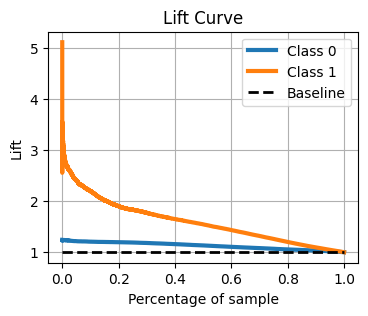

In [45]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('A23_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [46]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [47]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('A23_REPORT_importance_gain.csv'), index=True)

In [48]:
feat_impgain.head()

,importance
urban_flag,349.245728
NAICS_response,187.304657
LowDoc,156.372208
DisbursementGross,57.122231
franchise_flag,26.869673


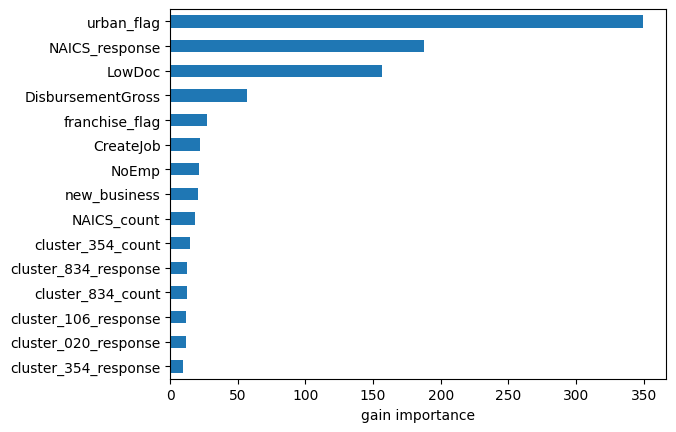

In [49]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('A23_PLOT_importance_gain.png'))

##### Permutation Importance

In [50]:
perm_importance = permutation_importance(xgb_model, 
                                         train_df[predictor_features],  train_df['target'],
                                         n_repeats=30, scoring = 'average_precision')

In [51]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [52]:
perm_importance_df.head(5)

,features,importance,abs_importance
7,NAICS_response,0.096107,0.096107
3,DisbursementGross,0.067238,0.067238
5,urban_flag,0.036096,0.036096
1,CreateJob,0.018956,0.018956
2,LowDoc,0.014756,0.014756


In [53]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('A23_DATA_importance_perturb.csv'),
            index=False)

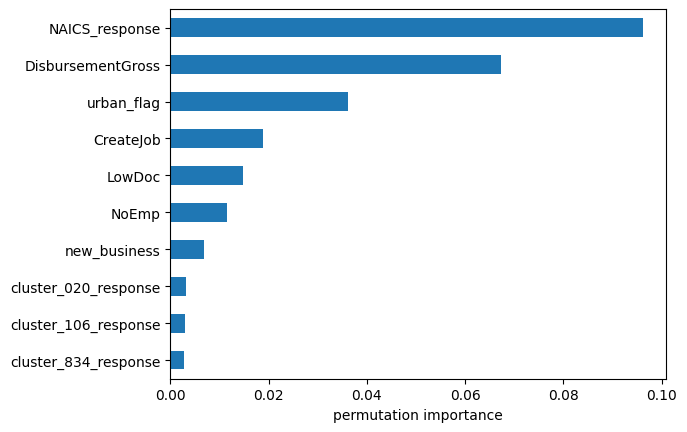

In [54]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('A23_PLOT_importance_perturb.png'))

## PDP Plot - encoding feature

In [55]:
feat_list = list(enc_val.columns)

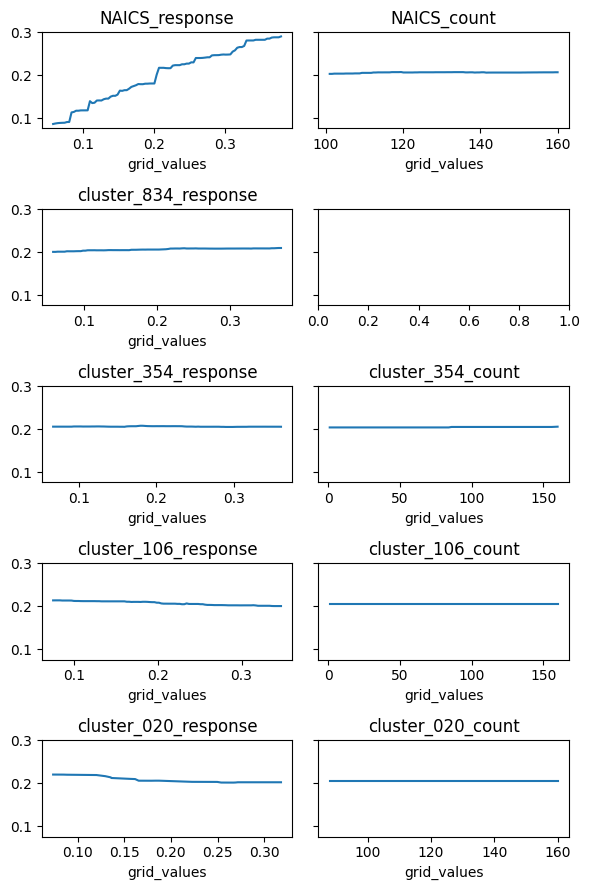

In [56]:
fig, ax = plt.subplots(int(np.ceil(len(feat_list)/2)), 2, sharex=False, 
                       sharey=True, figsize=(6, 9))
for i in range(len(feat_list)):
    col = int(i % 2)
    row = int(np.floor(i / 2))
    try:
        results = partial_dependence(xgb_model, train_df[predictor_features], 
                                     [feat_list[i]])
    except:
        continue
    pdp_df = pd.DataFrame({'grid_values':results["grid_values"][0],
                       'pdp':results["average"][0]})
    pdp_df.plot(x='grid_values', y='pdp', legend=None, ax=ax[row, col])
    ax[row, col].set_title(feat_list[i])

fig.tight_layout()
fig.savefig(Path(setup.temp_path).joinpath('A23_PLOT_pdp_combined.png'),
               bbox_inches='tight')
plt.show()